In [1]:
import os

import numpy as np
import pandas as pd
import anndata
import sklearn.decomposition as decomposition
import openTSNE

from atc_classification import ATC
import embedding_annotation as annotate

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv(os.path.join("..", "data", "2019-04.csv"), index_col=0)
df.shape

(12739, 829)

In [3]:
adata = anndata.AnnData(df.values, dtype=np.float32)
adata.obs_names = df.index.values
adata.var_names = df.columns.values
adata

AnnData object with n_obs × n_vars = 12739 × 829

In [4]:
levels = {
    1: slice(0, 1),
    2: slice(0, 3),
    3: slice(0, 4),
    4: slice(0, 5),
    5: slice(0, 7),
}
for l in levels:
    tmp = df.T

    tmp["group"] = tmp.index.str[levels[l]]
    tmp = tmp.groupby("group").sum()
    tmp = tmp.T
    tmp = tmp.loc[:, tmp.columns.str.len() == (levels[l].stop - levels[l].start)]

    adata.obsm[f"ATC_{l}"] = tmp

In [5]:
adata

AnnData object with n_obs × n_vars = 12739 × 829
    obsm: 'ATC_1', 'ATC_2', 'ATC_3', 'ATC_4', 'ATC_5'

### Filter out doctors with too few drug prescriptions

In [6]:
min_count = 25

adata.obs["prescription_count"] = adata.X.sum(axis=1)
adata = adata[adata.obs["prescription_count"] > min_count]

In [7]:
adata

View of AnnData object with n_obs × n_vars = 3925 × 829
    obs: 'prescription_count'
    obsm: 'ATC_1', 'ATC_2', 'ATC_3', 'ATC_4', 'ATC_5'

### Generate t-SNE embedding

In [8]:
pca = decomposition.PCA(n_components=50)
adata.obsm["X_pca"] = pca.fit_transform(adata.obsm["ATC_4"])

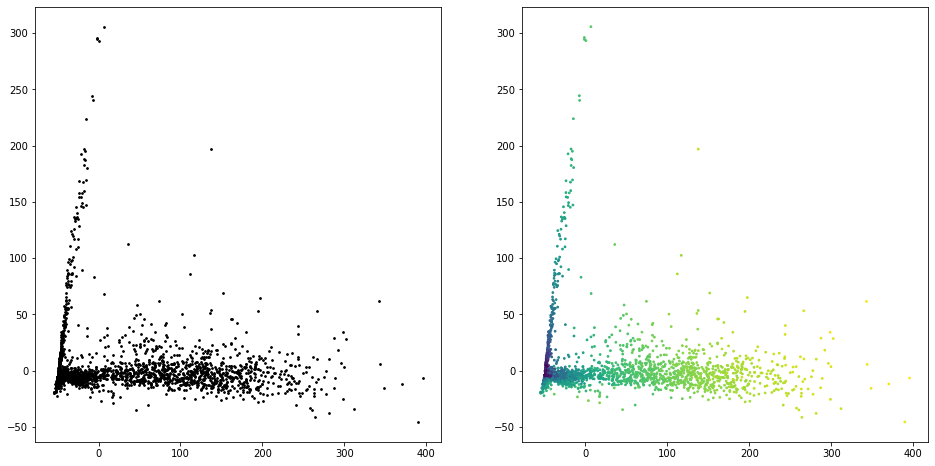

In [9]:
z = adata.obsm["X_pca"]
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(z[:, 0], z[:, 1], s=3, c="k")
ax[1].scatter(z[:, 0], z[:, 1], s=3, c=np.log(adata.obs["prescription_count"]))

In [10]:
adata.obsm["X_tsne"] = openTSNE.TSNE(
    metric="cosine", perplexity=50, exaggeration=1.5, dof=0.8, n_jobs=4
).fit(adata.obsm["X_pca"])

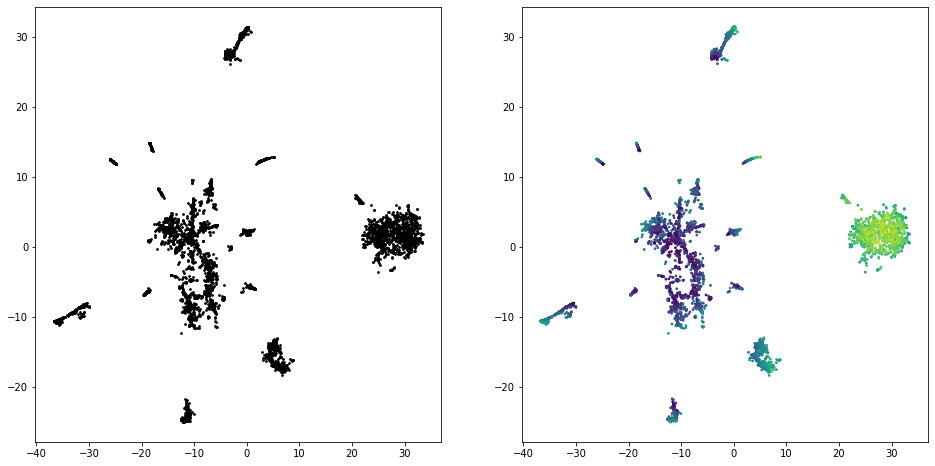

In [11]:
z = adata.obsm["X_tsne"]
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(z[:, 0], z[:, 1], s=3, c="k")
ax[1].scatter(z[:, 0], z[:, 1], s=3, c=np.log(adata.obs["prescription_count"]))

# Annotation pipeline

In [12]:
features = pd.concat([
    adata.obsm["ATC_1"],
    adata.obsm["ATC_2"],
    adata.obsm["ATC_3"],
], axis=1)
features.shape

(3925, 277)

In [13]:
features

group                                       A   B    C   D   G   H   J  L   M  \
predpis_zdravnik                                                                
0003CF5DF9C3D932F1A64EBF288F253205254CA4   10   3   10   0   0   0   3  0   0   
0009F6E1D43884A3F4E7962BFB6CA3B93D398778    3   2    0   0   0   0  20  0  23   
000DE52368D858D96734054B9F863E25E661758E   16   3    0  32   1   5  44  0  16   
000DE6DB7F96F91E0893D0880E6458A822C9B0E6   46  21   52  12   8   4  11  1  14   
000DFC4C5193052A7136995A29CE0F917285781C    5   0    6   4   5   0  40  0  25   
...                                       ...  ..  ...  ..  ..  ..  .. ..  ..   
FF7D37EC680E5E75BE7230B84B0EB42810909F89   45  10   20  40   5  16  67  0  28   
FF843C551CBF57E4C0758F0695476D96DA9A20A4  122  46  256  25  15  43  32  5  50   
FF96506331DF4FFCF40F33C860FE23A5FE644F12    0   0    2   0   0   0   0  0   0   
FFB4391E8BB04C1B59B70781623562A1122251A3    0   0    2   0   1   0   0  0   0   
FFCC4C50C379D6E397560AAED184A3AA2CF31175    5   0    3   1   1   9  14  2   0   

group                                       N  ...  S01E  S01F  S01G  S01X  \
predpis_zdravnik                               ...                           
0003CF5DF9C3D932F1A64EBF288F253205254CA4   36  ...     0     0     0     0   
0009F6E1D43884A3F4E7962BFB6CA3B93D398778   11  ...     0     0     0     0   
000DE52368D858D96734054B9F863E25E661758E   30  ...     0     0     4     0   
000DE6DB7F96F91E0893D0880E6458A822C9B0E6  136  ...     2     0     0     2   
000DFC4C5193052A7136995A29CE0F917285781C   47  ...     0     0     5     0   
...                                       ...  ...   ...   ...   ...   ...   
FF7D37EC680E5E75BE7230B84B0EB42810909F89   81  ...     0     0     7     0   
FF843C551CBF57E4C0758F0695476D96DA9A20A4  154  ...     3     0     5     7   
FF96506331DF4FFCF40F33C860FE23A5FE644F12   28  ...     0     0     0     0   
FFB4391E8BB04C1B59B70781623562A1122251A3   72  ...     0     0     0     0   
FFCC4C50C379D6E397560AAED184A3AA2CF31175    0  ...     0     0     6     0   

group                                     S03B  V01A  V03A  V06C  V06D  V07A  
predpis_zdravnik                                                              
0003CF5DF9C3D932F1A64EBF288F253205254CA4     0     0     0     0     0     0  
0009F6E1D43884A3F4E7962BFB6CA3B93D398778     0     0     0     0     8     0  
000DE52368D858D96734054B9F863E25E661758E     0     0     0     2     0     0  
000DE6DB7F96F91E0893D0880E6458A822C9B0E6     0     0     0     0     2     0  
000DFC4C5193052A7136995A29CE0F917285781C     0     0     0     0     0     0  
...                                        ...   ...   ...   ...   ...   ...  
FF7D37EC680E5E75BE7230B84B0EB42810909F89     0     0     0     0     1     0  
FF843C551CBF57E4C0758F0695476D96DA9A20A4     0     0     0     0    16     0  
FF96506331DF4FFCF40F33C860FE23A5FE644F12     0     0     0     0     0     0  
FFB4391E8BB04C1B59B70781623562A1122251A3     0     0     0     0     0     0  
FFCC4C50C379D6E397560AAED184A3AA2CF31175     0     9     0     0     0     0  

[3925 rows x 277 columns]

In [14]:
candidates = annotate.fs.morans_i(adata.obsm["X_tsne"], features)
candidates

feature  morans_i  pvalue  fdr
0         A  0.740208     0.0  0.0
1         B  0.717938     0.0  0.0
2         C  0.848183     0.0  0.0
3         D  0.661811     0.0  0.0
4         G  0.845585     0.0  0.0
..      ...       ...     ...  ...
269    S01G  0.500364     0.0  0.0
270    S01X  0.498971     0.0  0.0
272    V01A  0.101548     0.0  0.0
273    V03A  0.191346     0.0  0.0
275    V06D  0.288335     0.0  0.0

[191 rows x 4 columns]

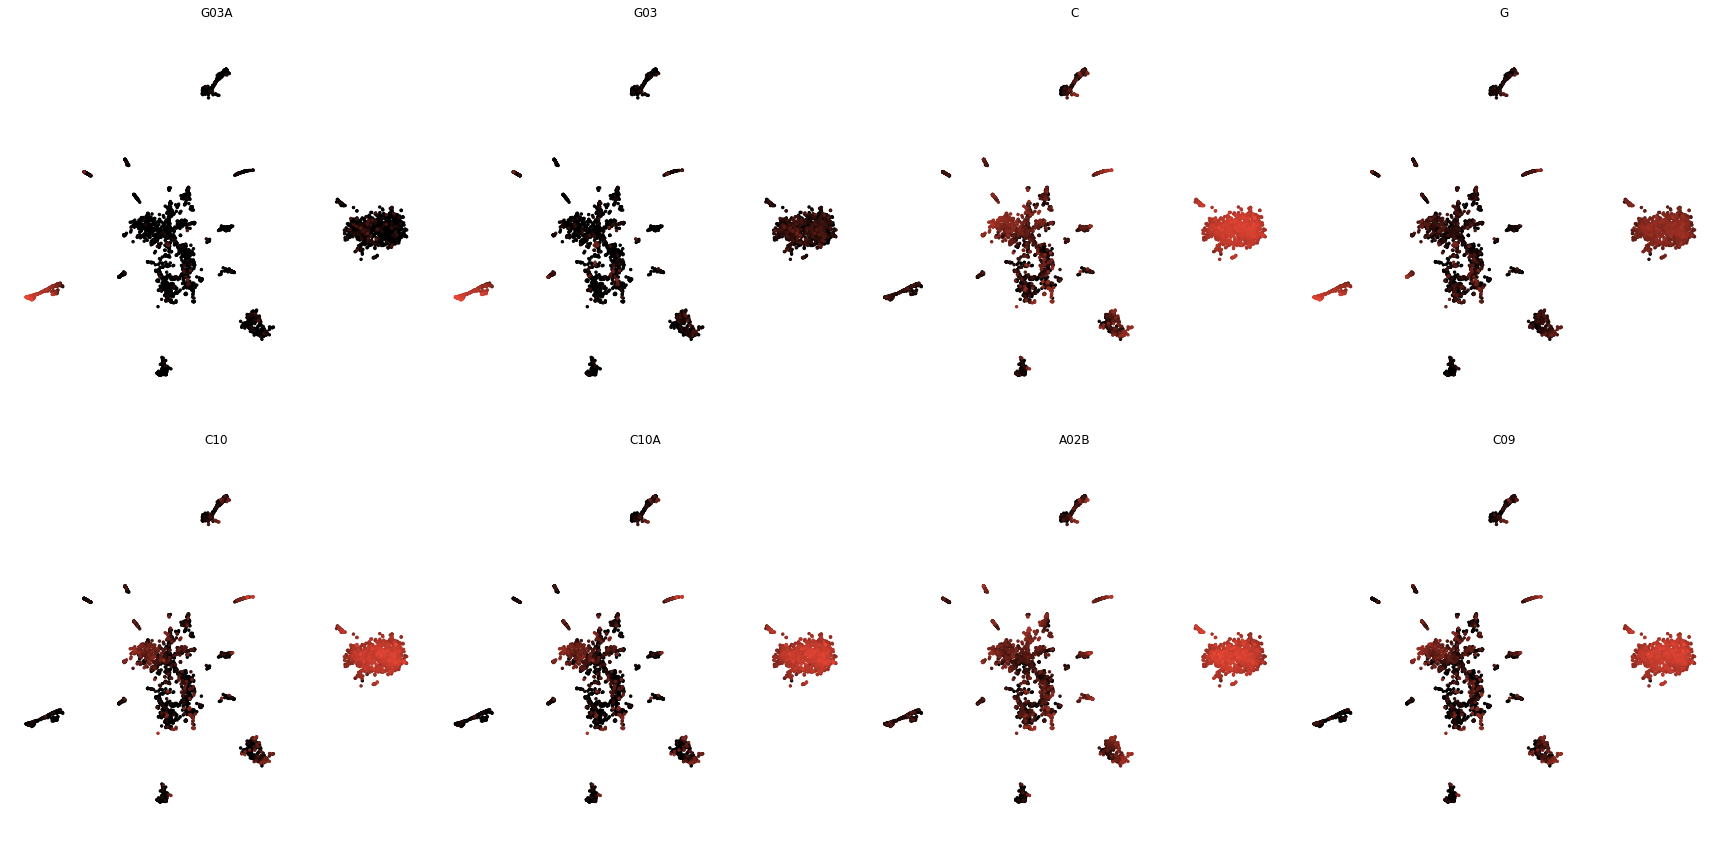

In [15]:
annotate.pl.plot_features(
    candidates.sort_values("morans_i", ascending=False)["feature"].tolist()[:8],
    features,
    adata.obsm["X_tsne"],
    s=6,
    alpha=1,
    log=True,
)

In [909]:
reload(annotate.an)
reload(annotate.pl)

<module 'embedding_annotation.plotting' from '/Users/pavlin/Dev/embedding_annotation/embedding_annotation/plotting.py'>

In [972]:
feature_densities = annotate.an.estimate_feature_densities(
    candidates["feature"].tolist(),
    adata.obsm["X_tsne"],
    features,
    log=True,
)

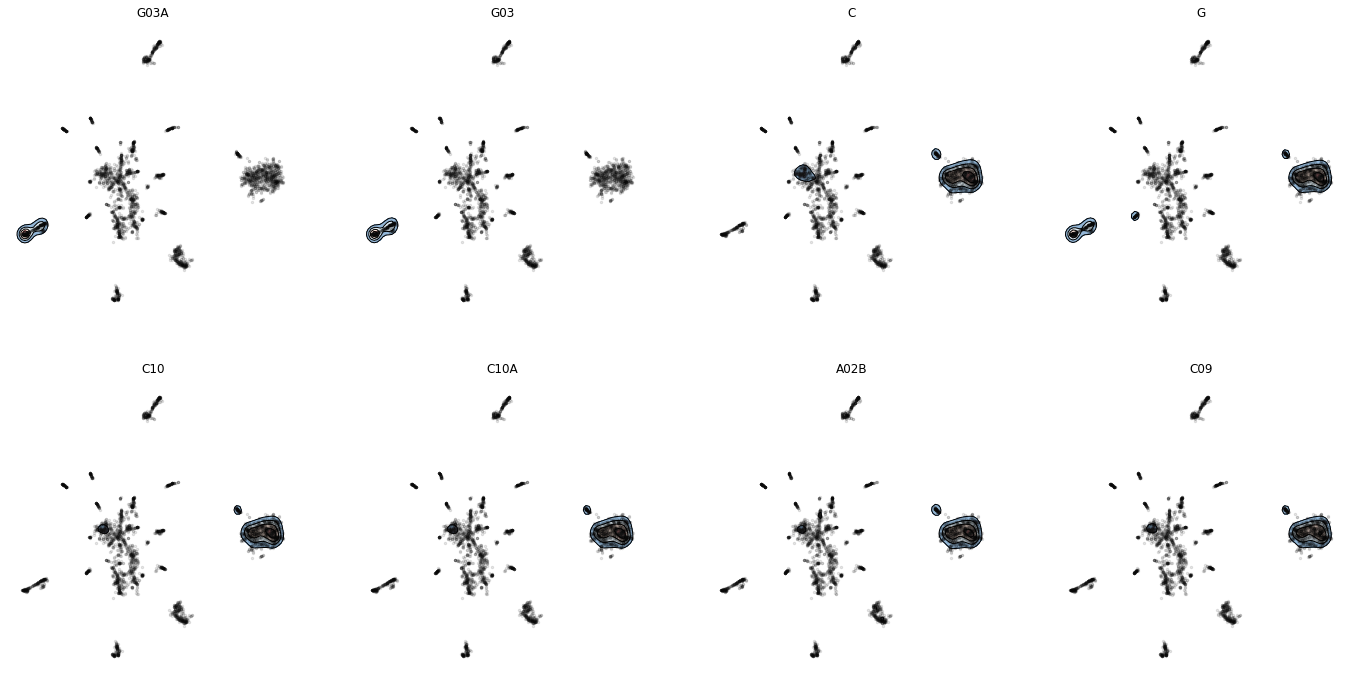

In [973]:
annotate.pl.plot_feature_densities(
    candidates.sort_values("morans_i", ascending=False)["feature"].tolist()[:8],
    feature_densities,
    embedding=adata.obsm["X_tsne"],
)

In [1028]:
%%time
reload(annotate.an)
clusters, cluster_densities = annotate.an.group_similar_features(
    candidates["feature"].tolist(),
    feature_densities,
    #similarity_threshold=0.1,
    #metric="js-divergence",
    #plot_dendrogram=True,
)
len(clusters)

CPU times: user 739 ms, sys: 13.6 ms, total: 753 ms
Wall time: 753 ms


89

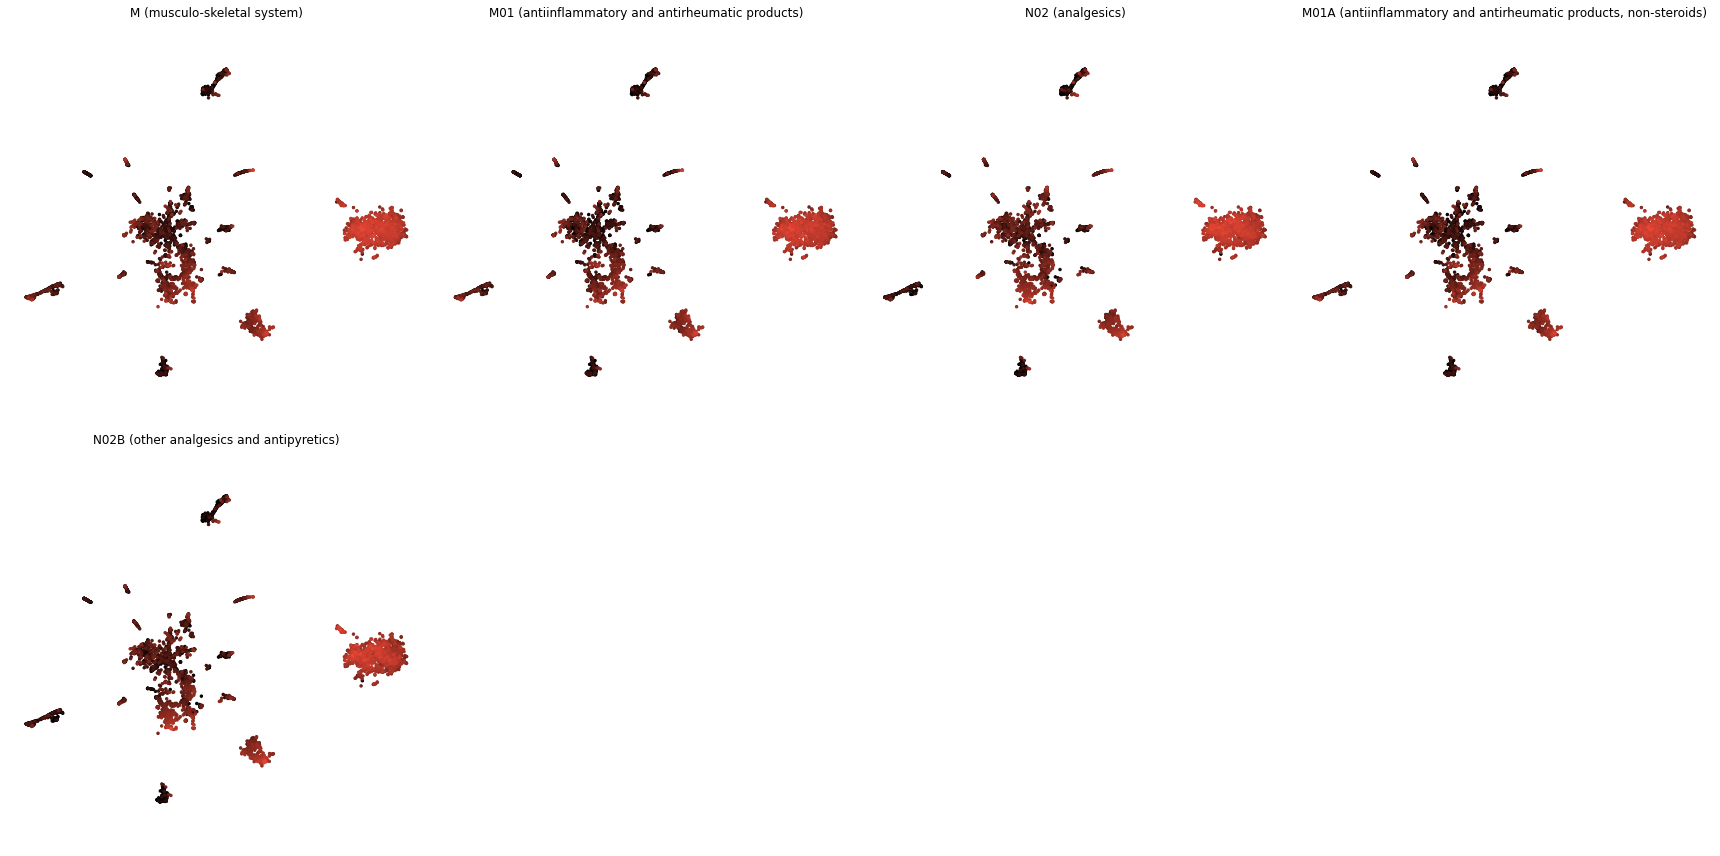

In [1029]:
fig, ax = annotate.pl.plot_features(
    clusters["Cluster 4"],
    features,
    adata.obsm["X_tsne"],
    s=6,
    alpha=1,
    log=True,
    return_ax=True,
)
for ax_ in ax:
    code = ax_.get_title()
    if code in ATC:
        ax_.set_title(str(ATC[code]))

In [1030]:
for c, v in clusters.items():
    print("-" * 80)
    print(f"{c}:", ", ".join(v))
    print(ATC.highlight_in_tree(v))

--------------------------------------------------------------------------------
Cluster 1: A09, A10, C01, C02, C03, C07, C08, C09, C10, H03, M04, M05, A09A, A10A, A10B, C01A, C01B, C01D, C01E, C02C, C03B, C03C, C03D, C07A, C07B, C08C, C08D, C09A, C09B, C09C, C09D, C10A, C10B, G04C, H03A, M04A, M05B
+- A (alimentary tract and metabolism)
	+- A09 (digestives, incl. enzymes)
		+- A09A (digestives, incl. enzymes)
	+- A10 (drugs used in diabetes)
		+- A10A (insulins and analogues)
		+- A10B (blood glucose lowering drugs, excl. insulins)
+- C (cardiovascular system)
	+- C01 (cardiac therapy)
		+- C01A (cardiac glycosides)
		+- C01B (antiarrhythmics, class i and iii)
		+- C01D (vasodilators used in cardiac diseases)
		+- C01E (other cardiac preparations)
	+- C02 (antihypertensives)
		+- C02C (antiadrenergic agents, peripherally acting)
	+- C03 (diuretics)
		+- C03B (low-ceiling diuretics, excl. thiazides)
		+- C03C (high-ceiling diuretics)
		+- C03D (aldosterone antagonists and other potassi

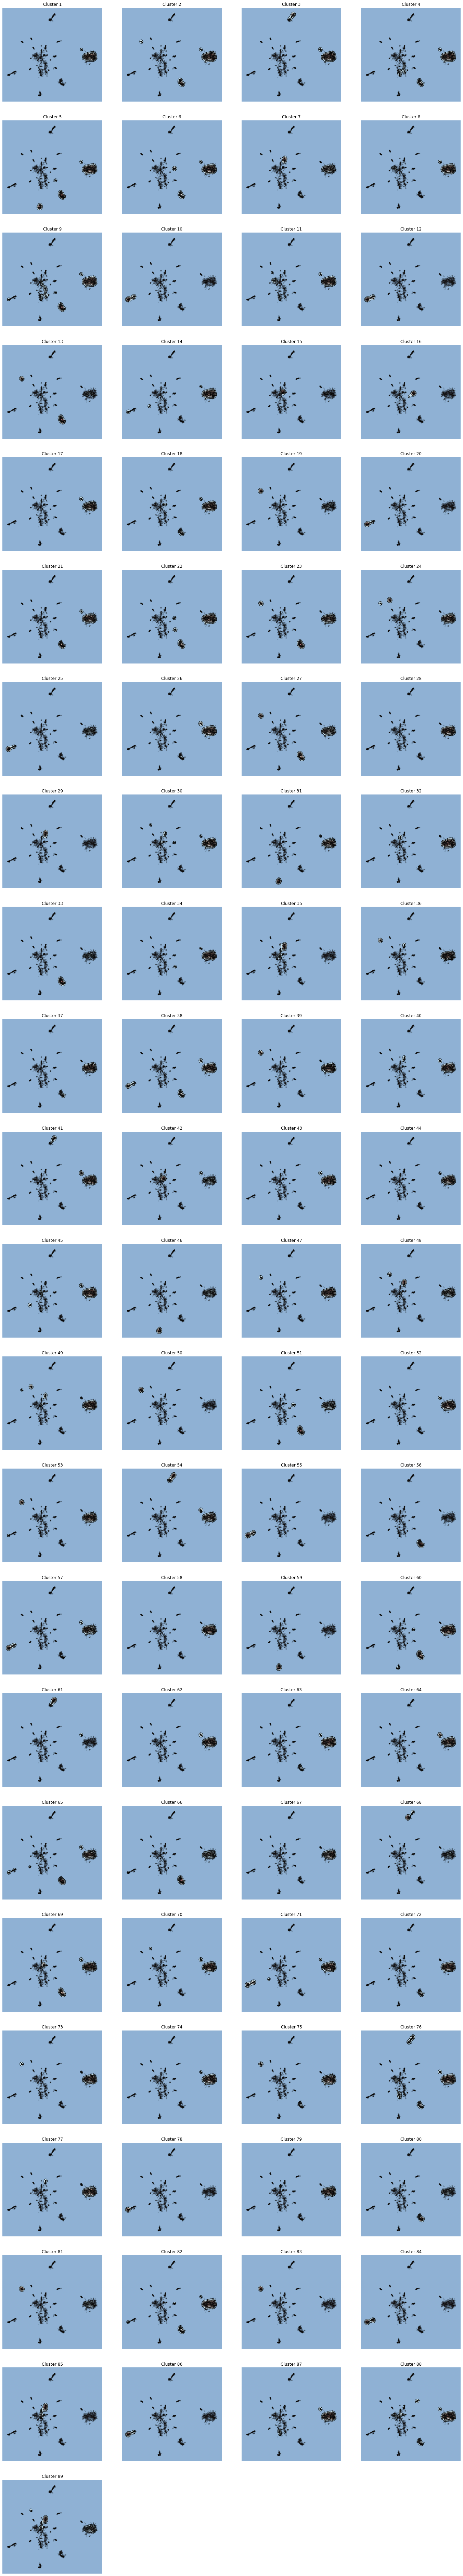

In [1031]:
annotate.pl.plot_feature_densities(
    list(clusters),
    cluster_densities,
    embedding=adata.obsm["X_tsne"],
    levels=4,
    skip_first=False,
    per_row=4,
)

In [1076]:
reload(annotate.an)
reload(annotate.g)
reload(annotate.pl)

<module 'embedding_annotation.plotting' from '/Users/pavlin/Dev/embedding_annotation/embedding_annotation/plotting.py'>

In [1077]:
independent_sets = annotate.an.optimize_layout(cluster_densities)
len(independent_sets)

1960

In [1078]:
np.random.shuffle(independent_sets)

In [1079]:
annotate.an.contour_overlap_area(cluster_densities["Cluster 1"], cluster_densities["Cluster 58"], level=0.2)

62.65586392505562

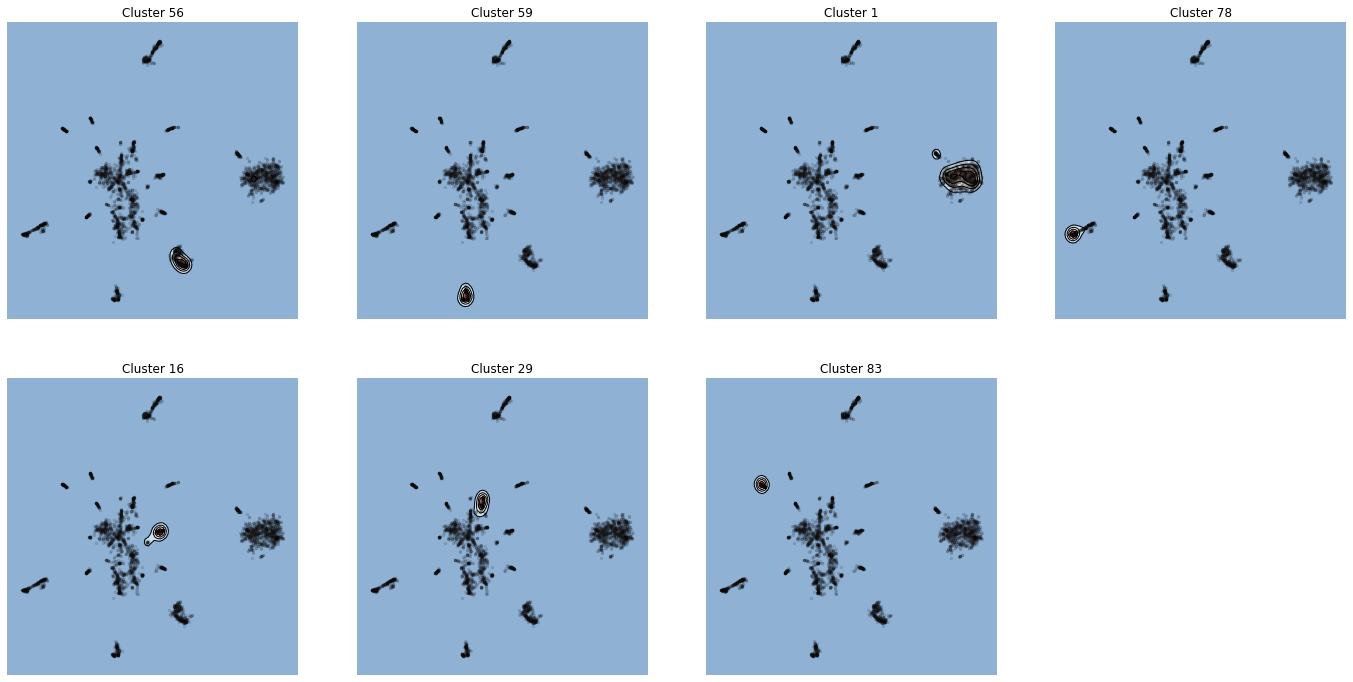

In [1081]:
annotate.pl.plot_feature_densities(
    independent_sets[2],
    cluster_densities,
    embedding=adata.obsm["X_tsne"],
    levels=4,
    skip_first=False,
    per_row=4,
)

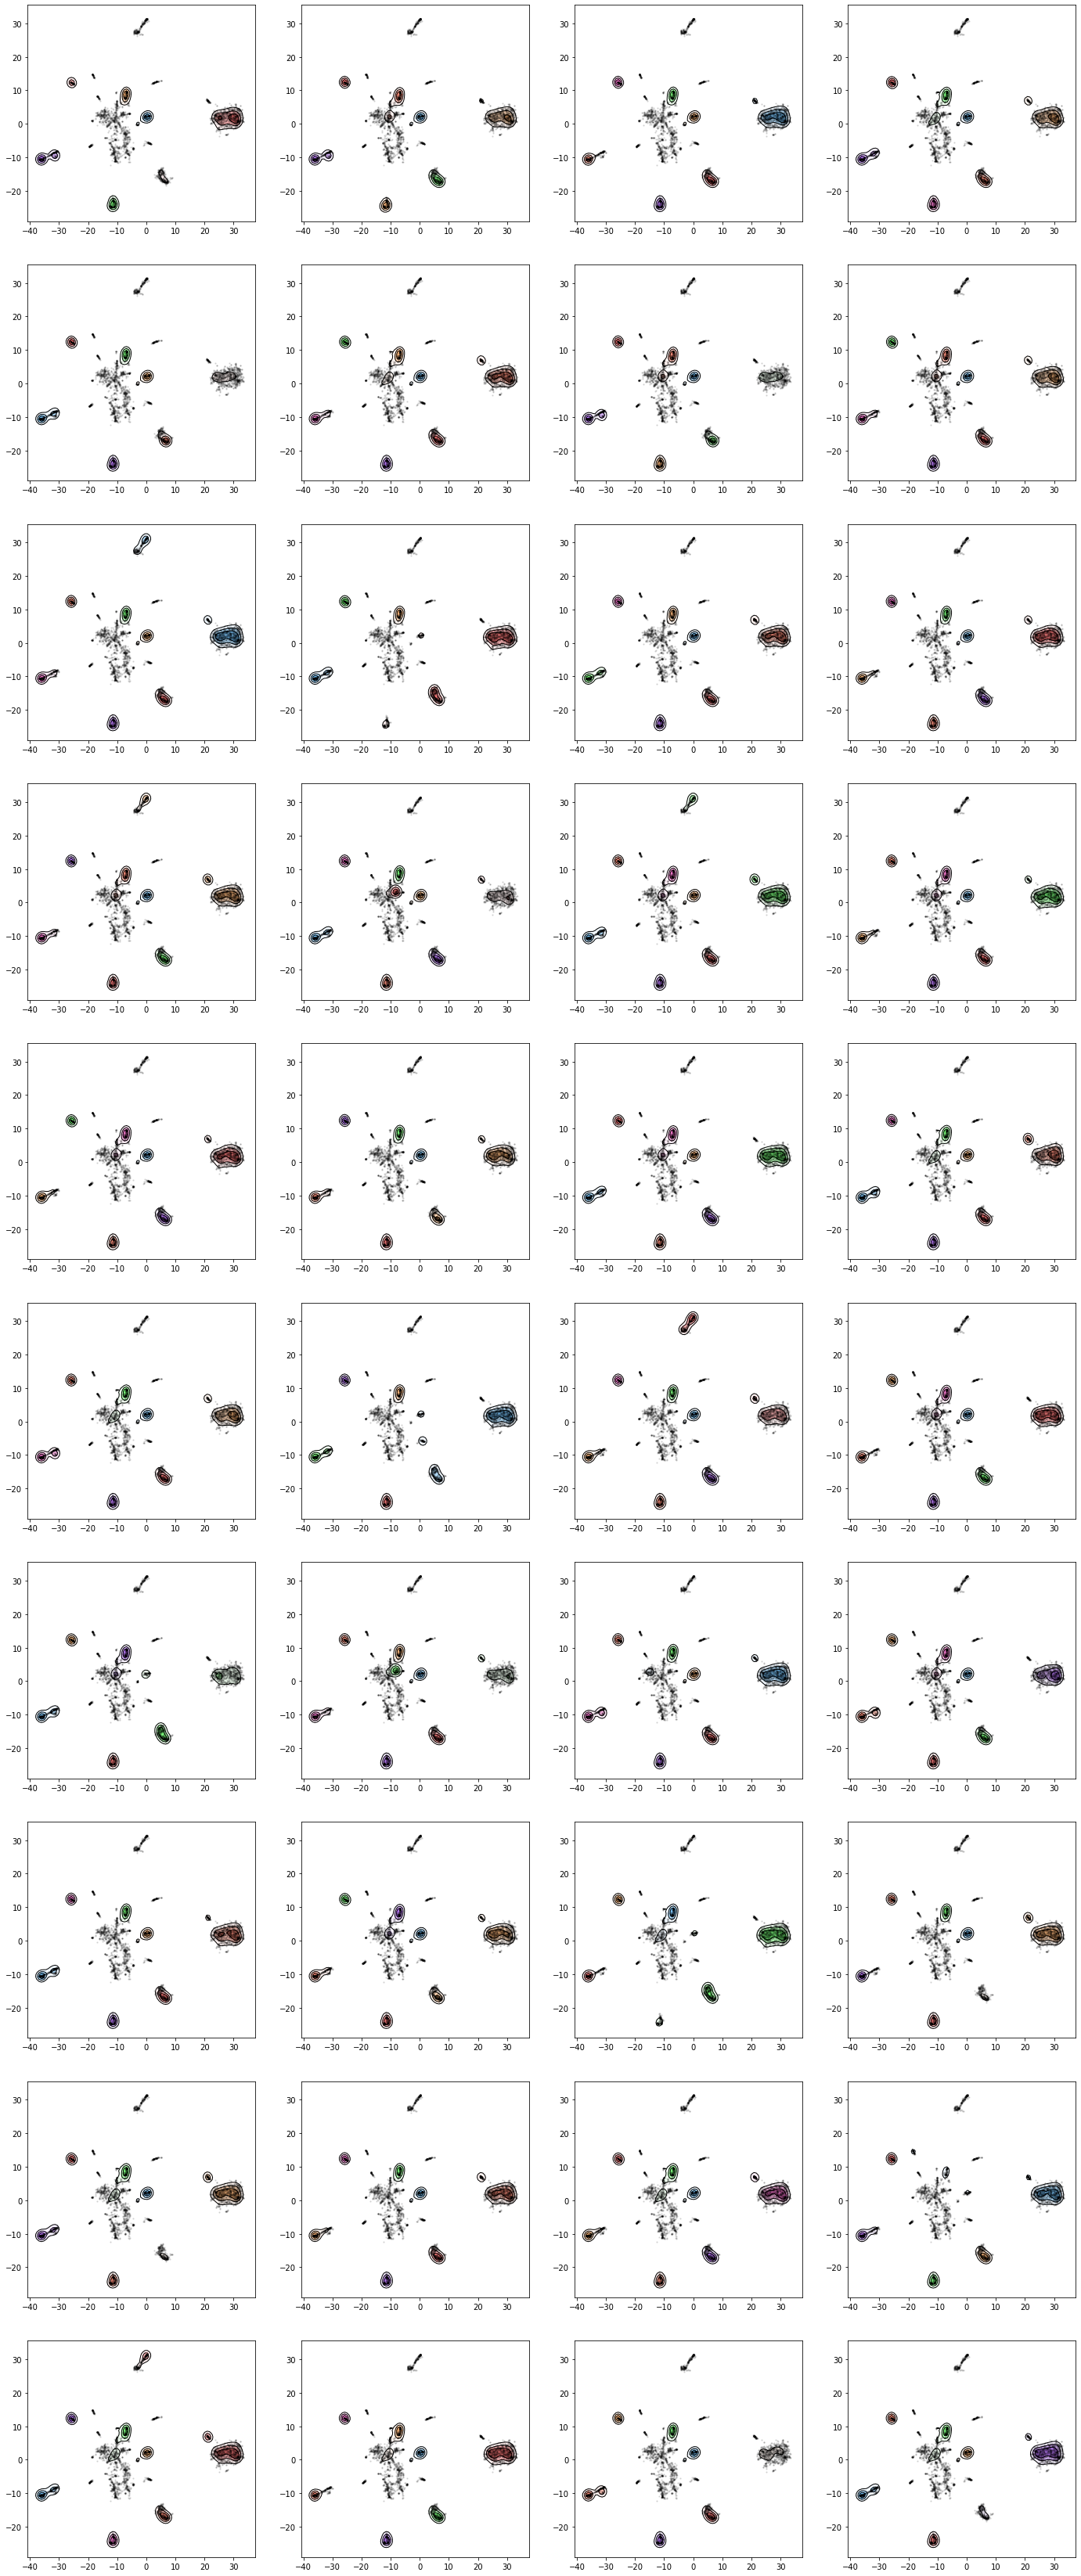

In [1084]:
max_plots = 40
items = independent_sets
per_line = 4
plot_width = 24

items = items[:max_plots]
num_lines = min(int(np.ceil(len(items) / per_line)), int(np.ceil(max_plots / per_line)))

fig, ax = plt.subplots(nrows=num_lines, ncols=per_line, figsize=(plot_width, plot_width / per_line * num_lines))

for ax_, item in zip(ax.ravel(), items):
    annotate.pl.plot_annotation(
        {k: d for k, d in cluster_densities.items() if k in item},
        adata.obsm["X_tsne"],
        scatter_kwargs=dict(s=2),
        ax=ax_,
    )

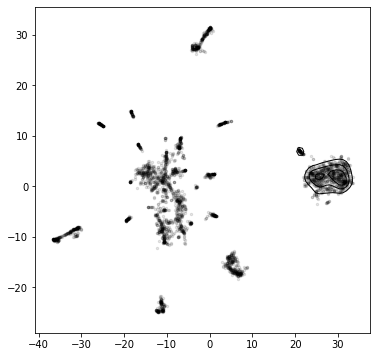

In [707]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], **scatter_kwargs_)
ct = ax.contour(xs, ys, z, levels=4, locator=tck, **contour_kwargs_)
ax.add_collection(ct.collections[0])

In [829]:
def contour_overlap_area(p1, p2, threshold=0.25):
    # Rescale both densities to max=1
    p1 = p1 / p1.max()
    p2 = p2 / p2.max()

    # Obtain contours from both density plots at the given threshold
    contour_generator_p1 = contourpy.contour_generator(xs, ys, p1.reshape((100, 100)), corner_mask=False)
    contour_generator_p2 = contourpy.contour_generator(xs, ys, p2.reshape((100, 100)), corner_mask=False)

    p1_contours = contour_generator_p1.lines(threshold)
    p2_contours = contour_generator_p2.lines(threshold)

    overlapping_area = 0
    for c1 in p1_contours:
        c1_poly = geom.Polygon(c1)
        for c2 in p2_contours:
            c2_poly = geom.Polygon(c2)
            overlapping_area += c1_poly.intersection(c2_poly).area

    return overlapping_area

In [831]:
contour_overlap_area(feature_densities.iloc[0].values,
                     feature_densities.iloc[0].values)

85.76307893970487

In [744]:
import contourpy

In [773]:
contour_generator = contourpy.contour_generator(
    xs, ys, z,
    corner_mask=False,
    chunk_size=0,
)
contour_generator

In [791]:
ctf.levels

array([0.   , 0.002, 0.004, 0.006, 0.008])

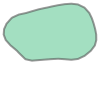

In [789]:
geom.Polygon(contour_generator.lines(0.002)[0])

In [777]:
import shapely.geometry as geom

In [778]:
s1 = geom.Polygon(ct.collections[1].get_paths()[0].vertices)
s2 = geom.Polygon(ct.collections[2].get_paths()[0].vertices)

In [779]:
s1.intersection(s2).area

33.617518511811205

In [742]:
s2.area

33.6175185118112

In [722]:
ct.collections[3].get_paths()[0].codes

array([ 1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2, 79], dtype=uint8)

In [693]:
len(ct.allsegs), ct.allsegs[1]

(5,
 [array([[24.84457678, -1.35893922],
         [25.63541696, -1.53164395],
         [26.42625715, -1.46817069],
         [27.21709734, -1.40409406],
         [28.00793752, -1.34636678],
         [28.79877771, -1.3040714 ],
         [29.58961789, -1.35847991],
         [30.38045808, -1.42463651],
         [31.17129826, -1.33043585],
         [31.86062905, -1.00273817],
         [31.96213845, -0.96064426],
         [32.715772  , -0.35037511],
         [32.75297863, -0.30554677],
         [33.20963109,  0.30198794],
         [33.38371324,  0.954351  ],
         [33.37273545,  1.60671406],
         [33.24819331,  2.25907712],
         [33.0708895 ,  2.91144018],
         [32.85053433,  3.56380324],
         [32.75297863,  3.77206154],
         [32.53572117,  4.21616629],
         [31.96213845,  4.85289103],
         [31.93470609,  4.86852935],
         [31.17129826,  5.23680718],
         [30.38045808,  5.3276619 ],
         [29.58961789,  5.27252429],
         [28.79877771,  5.14976367

In [660]:
from importlib import reload
reload(annotate)
reload(annotate.feature_selection)
reload(annotate.annotate)
reload(annotate.plotting)

<module 'embedding_annotation.plotting' from '/Users/pavlin/Dev/embedding_annotation/embedding_annotation/plotting.py'>

<AxesSubplot:>

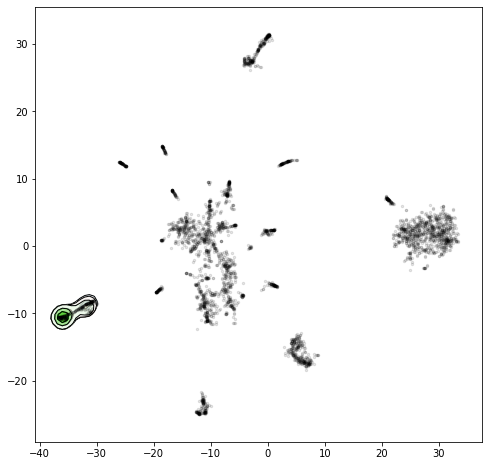

In [661]:
ann_map = annotate.an.AnnotationMap(grid, embedding=adata.obsm["X_tsne"])
ann_map = ann_map.add("Cluster 0", cluster_densities.iloc[0].values)
ann_map = ann_map.add("Cluster 2", cluster_densities.iloc[2].values)
ann_map = ann_map.add("Cluster 3", cluster_densities.iloc[3].values)
ann_map.plot_annotation()

In [662]:
ann_map.rank_overlap_densities(cluster_densities).sort_values("score").head()

AttributeError: 'AnnotationMap' object has no attribute 'rank_overlap_densities'

In [ ]:
ann_map.plot_overlap_with(cluster_densities.loc["Cluster 4"].values)

<AxesSubplot:>

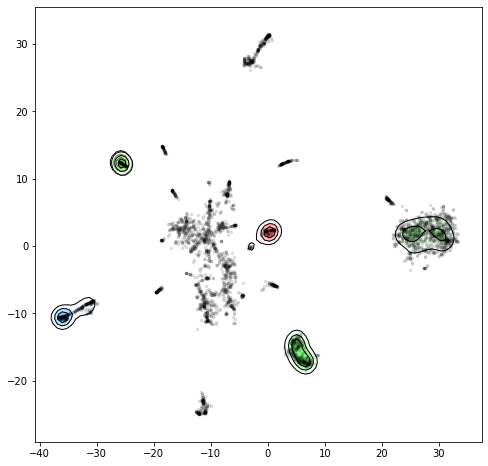

In [26]:
ann_map = ann_map.add("Cluster 21", cluster_densities.iloc[21].values)
ann_map.plot_annotation()

In [27]:
from scipy.interpolate import interp2d, griddata

In [28]:
# Estimate the likelihood of the points using the current 
z0 = griddata(grid, cluster_densities.loc["Cluster 3"], adata.obsm["X_tsne"].view(np.ndarray))

ll = -np.mean(np.log(z0))
ll

7.796384083847545

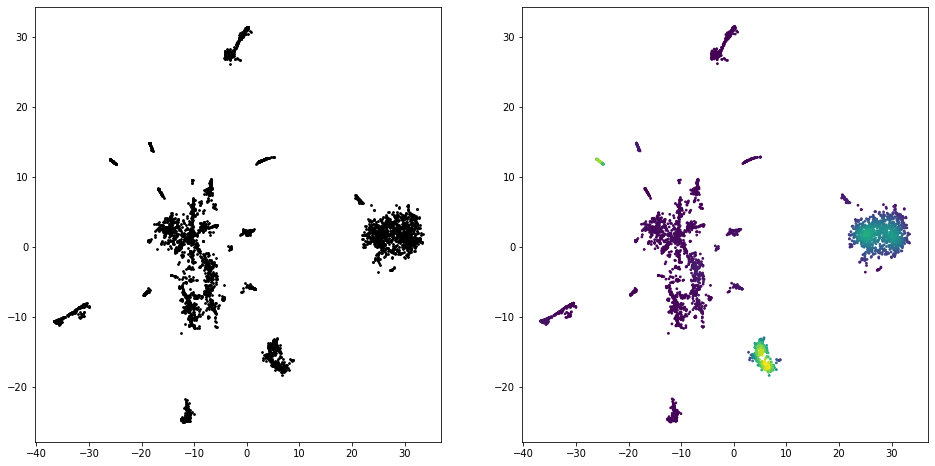

In [29]:
z = adata.obsm["X_tsne"]
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(z[:, 0], z[:, 1], s=3, c="k")
ax[1].scatter(z[:, 0], z[:, 1], c=z0, s=3)

In [30]:
from importlib import reload
reload(annotate)
reload(annotate.feature_selection)
reload(annotate.annotate)
reload(annotate.plotting)

<module 'embedding_annotation.plotting' from '/Users/pavlin/Dev/embedding_annotation/embedding_annotation/plotting.py'>

In [31]:
t = np.array([0.1, 0.2, 0.3])
t /= t.sum()
t
-np.sum(t * np.log(t))

1.0114042647073518

In [32]:
grid

array([[-40.7951586 , -29.05434968],
       [-40.7951586 , -28.40198663],
       [-40.7951586 , -27.74962357],
       ...,
       [ 37.49801974,  34.22486698],
       [ 37.49801974,  34.87723004],
       [ 37.49801974,  35.5295931 ]])

Cluster 10 -6.958404345985085
Cluster 20 -6.93082842226435


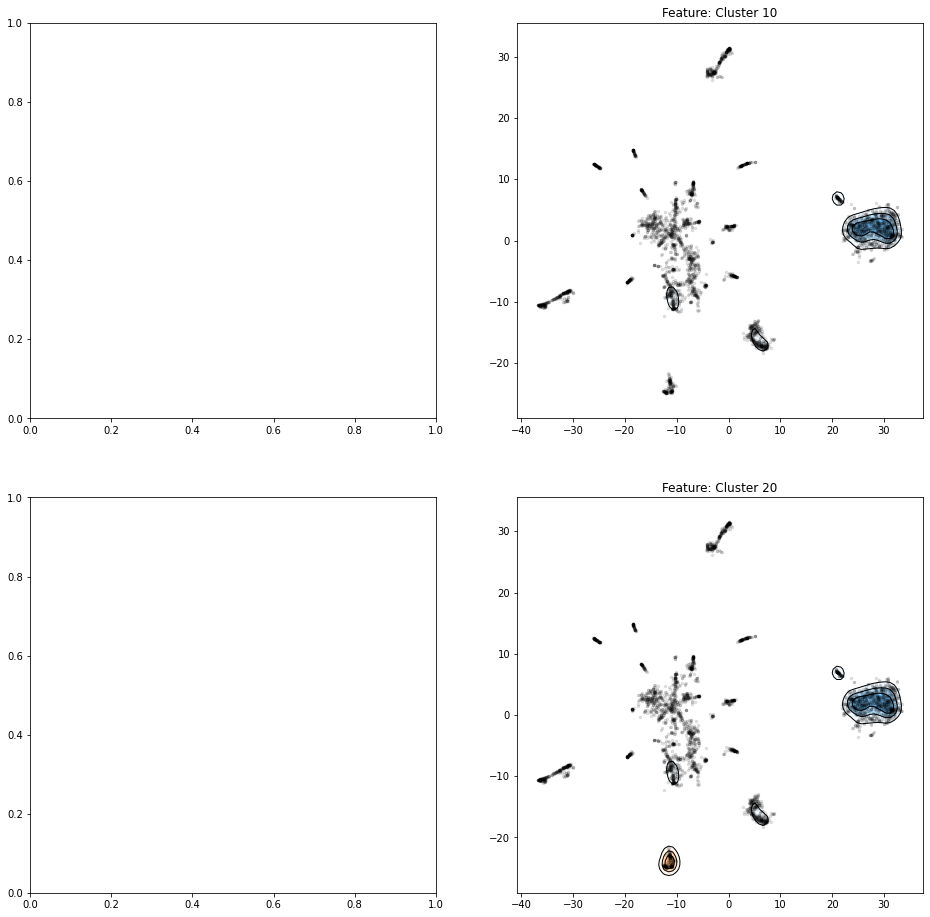

In [33]:
ann_map = annotate.an.AnnotationMap(grid, embedding=adata.obsm["X_tsne"])

nrows = 2
fig, ax = plt.subplots(figsize=(16, nrows * 8), nrows=nrows, ncols=2)

for i in range(nrows):

    best_candidate = None
    best_ll = -np.inf
    for name, candidate_density in cluster_densities.iterrows():
        if name in ann_map:
            continue
        ann_map = ann_map.add(name, candidate_density)
        z0 = griddata(grid, ann_map.joint_density, adata.obsm["X_tsne"].view(np.ndarray))
        ll = np.mean(np.log(z0))
        ann_map = ann_map.remove(name)

        if ll > best_ll:
            best_ll, best_candidate = ll, name

    ann_map = ann_map.add(best_candidate, cluster_densities.loc[best_candidate].values)
    print(best_candidate, best_ll)
    
    ann_map.plot_annotation(ax=ax[i, 1])
    ax[i, 1].set_title(f"Feature: {best_candidate}")

Cluster 10 -6.958404345985085
Cluster 20 -6.93082842226435


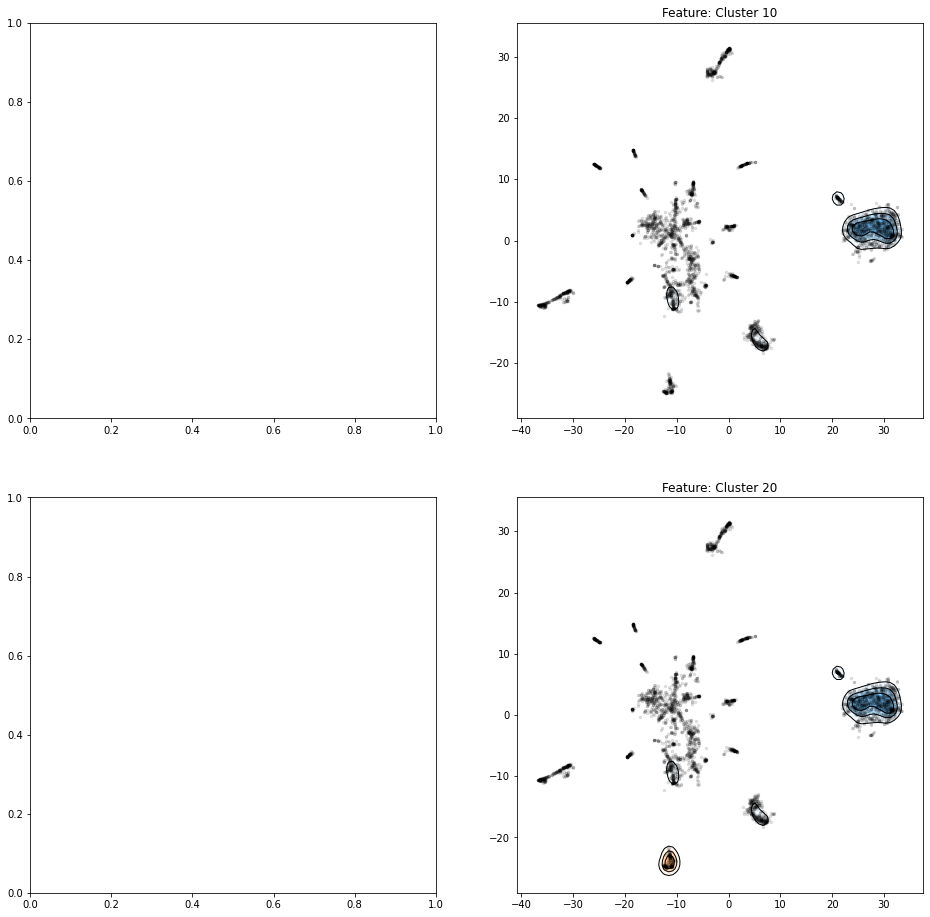

In [34]:
ann_map = annotate.an.AnnotationMap(grid, embedding=adata.obsm["X_tsne"])

nrows = 2
fig, ax = plt.subplots(figsize=(16, nrows * 8), nrows=nrows, ncols=2)

for i in range(nrows):

    best_candidate = None
    best_ll = -np.inf
    for name, candidate_density in cluster_densities.iterrows():
        if name in ann_map:
            continue
        ann_map = ann_map.add(name, candidate_density)
        z0 = griddata(grid, ann_map.joint_density, adata.obsm["X_tsne"].view(np.ndarray))
        ll = np.mean(np.log(z0))
        ann_map = ann_map.remove(name)

        if ll > best_ll:
            best_ll, best_candidate = ll, name

    ann_map = ann_map.add(best_candidate, cluster_densities.loc[best_candidate].values)
    print(best_candidate, best_ll)
    
    ann_map.plot_annotation(ax=ax[i, 1])
    ax[i, 1].set_title(f"Feature: {best_candidate}")

In [35]:
from scipy.special import softmax

ann_map = annotate.an.AnnotationMap(grid, embedding=adata.obsm["X_tsne"])
ann_map = ann_map.add("Cluster 0", cluster_densities.iloc[0].values)
ann_map = ann_map.add("Cluster 2", cluster_densities.iloc[2].values)
ann_map = ann_map.add("Cluster 3", cluster_densities.iloc[3].values)
ann_map = ann_map.add("Cluster 12", cluster_densities.iloc[12].values)
ann_map = ann_map.add("Cluster 21", cluster_densities.iloc[21].values)
#ann_map = ann_map.add("Cluster 11", cluster_densities.iloc[11].values)
#ann_map.plot_annotation()

#adata.obsm["X_tsne"]
#
#z0 = griddata(grid, cluster_densities.loc["Cluster 3"], adata.obsm["X_tsne"].view(np.ndarray))

i = 0
p = adata.obsm["X_tsne"][i].view(np.ndarray)

soft_assignment = []
for name, d in ann_map.scaled_densities.items():
    z0 = griddata(grid, d, adata.obsm["X_tsne"].view(np.ndarray))
    soft_assignment.append(z0)
soft_assignment = np.vstack(soft_assignment).T
    
base_p = 1 / soft_assignment.shape[1]
base_h = -soft_assignment.shape[1] * base_p * np.log(base_p)

soft_assignment = np.maximum(soft_assignment, 0.1)  # add a "compete-threshold"
soft_assignment = soft_assignment / soft_assignment.sum(axis=1, keepdims=True)
soft_assignment

array([[0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.05544555, 0.05544555, 0.46105635, 0.37260699, 0.05544555],
       ...,
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.06470463, 0.06470463, 0.06470463, 0.27258957, 0.53329653]])

In [36]:
h = -np.sum(soft_assignment * np.log(soft_assignment), axis=1)
h /= np.log(soft_assignment.shape[1])
#h /= soft_assignment.shape[1]
h

array([1.        , 1.        , 0.74928   , ..., 1.        , 1.        ,
       0.75868045])

In [37]:
np.mean(h - base_h)

-0.6907953435355194

In [38]:
h.mean()

0.9186425688985805

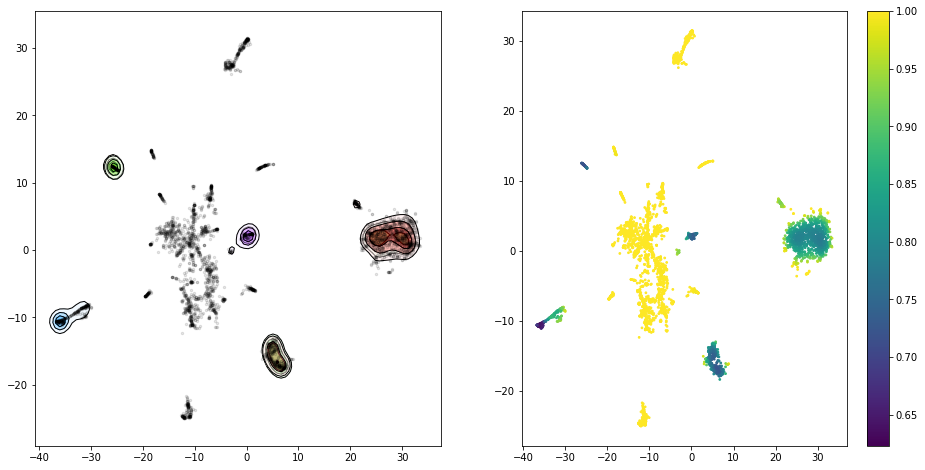

In [39]:
z = adata.obsm["X_tsne"]
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ann_map.plot_annotation(ax=ax[0])
sc = ax[1].scatter(z[:, 0], z[:, 1], c=h, s=3)
plt.colorbar(sc)